In [1]:
import os
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from cathedral_rl import cathedral_v0  
import random
import numpy as np

In [2]:
################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")



Device set to : NVIDIA RTX A5000


In [3]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
        self.action_masks = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]
        del self.action_masks[:]


class ActorCritic(nn.Module):
    def __init__(self, obs_shape, action_dim):
        super(ActorCritic, self).__init__()
        
        # Calculate input size from observation shape
        self.state_dim = obs_shape[0] * obs_shape[1] * obs_shape[2]  # Flattened input
        self.action_dim = action_dim

        # Actor network - outputs action probabilities
        self.actor = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
            # No softmax here - will apply it with action mask later
        )
        
        # Critic network - outputs state value
        self.critic = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, action_mask):
        # Flatten state for linear layers
        state_flat = state.reshape(-1)
        
        # Get action logits from actor
        action_logits = self.actor(state_flat)
        
        # Apply action mask (set invalid actions to negative infinity)
        action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)
        action_logits[~action_mask_tensor] = -1e8
        
        # Apply softmax to get action probabilities
        action_probs = torch.softmax(action_logits, dim=0)
        
        # Create categorical distribution
        dist = Categorical(action_probs)
        
        # Sample action
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        # Get state value from critic
        state_val = self.critic(state_flat)
        
        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, states, actions, action_masks):
        # Flatten states for linear layers
        batch_size = states.shape[0]
        states_flat = states.reshape(batch_size, -1)
        
        # Get action logits from actor for all states
        action_logits = self.actor(states_flat)
        
        # Apply action masks (set invalid actions to negative infinity)
        for i in range(batch_size):
            action_mask = action_masks[i]
            action_logits[i][~action_mask] = -1e8
        
        # Apply softmax to get action probabilities
        action_probs = torch.softmax(action_logits, dim=1)
        
        # Create categorical distributions
        dist = Categorical(action_probs)
        
        # Get log probabilities, entropies, and state values
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        state_values = self.critic(states_flat)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, obs_shape, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()
        
        self.policy = ActorCritic(obs_shape, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        
        self.policy_old = ActorCritic(obs_shape, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, action_mask):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            action_mask_tensor = torch.BoolTensor(action_mask).to(device)
            action, action_logprob, state_val = self.policy_old.act(state_tensor, action_mask_tensor)
        
        self.buffer.states.append(state_tensor)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)
        self.buffer.action_masks.append(action_mask_tensor)
        
        return action.item()
    
    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            #print(f'reward {reward}, is terminal {is_terminal}')
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards (if there are any)
        if len(rewards) > 0:
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            #print(f' reward normalisation {rewards}')
            if rewards.std() > 0:
                rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        else:
            return  # Nothing to update if buffer is empty
        
        # Convert lists to tensors
        old_states = torch.stack(self.buffer.states).detach().to(device)
        old_actions = torch.stack(self.buffer.actions).detach().to(device)
        old_logprobs = torch.stack(self.buffer.logprobs).detach().to(device)
        old_state_values = torch.stack(self.buffer.state_values).detach().squeeze().to(device)
        old_action_masks = torch.stack(self.buffer.action_masks).detach().to(device)
        
        # Calculate advantages
        advantages = rewards - old_state_values
        #print(f'Advantages {advantages.mean()}, rewards {rewards.mean()} old state values {old_state_values.mean()}')
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions, old_action_masks)
            
            # Match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            mse_loss = self.MseLoss(state_values, rewards)
            #print(f' surr1 {surr1.mean()}, surr2{surr2.mean()} mse loss * 0.5 {mse_loss.mean() * 0.5} dist entropy * 0.01 {0.01 * dist_entropy.mean()}')
            
            # Final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * mse_loss - 0.01 * dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # Clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [ ]:
class ActorCriticCNN(nn.Module):
    def __init__(self, obs_shape, action_dim):
        super(ActorCriticCNN, self).__init__()
        
        # Extract observation dimensions
        self.channels = obs_shape[2]
        self.height = obs_shape[1]   
        self.width = self.height 
        self.action_dim = action_dim
        print(f'Loading PPO CNN with {self.channels}, height {self.height}, width {self.width}')
        # Shared convolutional layers
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(self.channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Calculate the size after convolutions (unchanged if proper padding is used)
        conv_output_size = 64 * self.height * self.width
        
        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.action_dim)
            # No softmax - will apply with action mask later
        )
        
        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def _get_conv_features(self, state):
        # Process the state through the shared CNN layers
        x = self.shared_cnn(state)
        return x.view(x.size(0), -1) if x.dim() > 2 else x.view(1, -1)
    
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, action_mask):
        # Ensure state has batch dimension and channel-first format
        if state.dim() == 3:  # If no batch dimension
            state = state.unsqueeze(0)  # Add batch dimension
        
        # Get shared features
        features = self._get_conv_features(state)
        features = features.squeeze(0)  # Remove batch dimension for single sample
        
        # Get action logits
        action_logits = self.actor(features)
        
        # Apply action mask
        action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)
        action_logits[~action_mask_tensor] = -1e8
        
        # Apply softmax
        action_probs = torch.softmax(action_logits, dim=0)
        
        # Create distribution
        dist = Categorical(action_probs)
        
        # Sample action
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        # Get state value
        state_val = self.critic(features)
        
        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, states, actions, action_masks):
        # Ensure proper dimensions for CNN input
        batch_size = states.shape[0]
        
        # Get shared features
        features = self._get_conv_features(states)
        
        # Get action logits for all states
        action_logits = self.actor(features)
        
        # Apply action masks
        for i in range(batch_size):
            action_mask = action_masks[i]
            action_logits[i][~action_mask] = -1e8
        
        # Apply softmax
        action_probs = torch.softmax(action_logits, dim=1)
        
        # Create distributions
        dist = Categorical(action_probs)
        
        # Get log probabilities, entropies, and state values
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        state_values = self.critic(features)
        
        return action_logprobs, state_values, dist_entropy


# Modified PPO class to use the CNN model
class PPOCNN:
    def __init__(self, obs_shape, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()
        
        self.policy = ActorCriticCNN(obs_shape, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic},
            {'params': self.policy.shared_cnn.parameters(), 'lr': lr_actor}
        ])
        
        self.policy_old = ActorCriticCNN(obs_shape, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, action_mask):
        with torch.no_grad():
            # Convert state to proper format (C, H, W)
            state_tensor = torch.FloatTensor(state).to(device)
            # Make sure we have channels first format
            if state_tensor.dim() == 3 and state_tensor.shape[0] != 5:
                # Assuming the first dimension should be channels, but it's not
                state_tensor = state_tensor.permute(2, 0, 1)
                
            action_mask_tensor = torch.BoolTensor(action_mask).to(device)
            action, action_logprob, state_val = self.policy_old.act(state_tensor, action_mask_tensor)
        
        self.buffer.states.append(state_tensor)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)
        self.buffer.action_masks.append(action_mask_tensor)
        
        return action.item()
    
    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards (if there are any)
        if len(rewards) > 0:
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            if rewards.std() > 0:
                rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        else:
            return  # Nothing to update if buffer is empty
        
        # Convert lists to tensors
        old_states = torch.stack(self.buffer.states).detach().to(device)
        old_actions = torch.stack(self.buffer.actions).detach().to(device)
        old_logprobs = torch.stack(self.buffer.logprobs).detach().to(device)
        old_state_values = torch.stack(self.buffer.state_values).detach().squeeze().to(device)
        old_action_masks = torch.stack(self.buffer.action_masks).detach().to(device)
        
        # Calculate advantages
        advantages = rewards - old_state_values
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions, old_action_masks)
            
            # Match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            mse_loss = self.MseLoss(state_values, rewards)
            
            # Final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * mse_loss - 0.01 * dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # Clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [10]:
has_continuous_action_space = False

K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.95                # discount factor

lr_actor = 0.005       # learning rate for actor network
lr_critic = 0.002

In [11]:
board_size = 8
num_episodes = 1000
save_freq = 500
factor_illegal_action = 1

### Pure self play of PPO vs itself

In [12]:
def train_ppo_self_play(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    player_1 = "player_1"
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize PPO agent (will be used for both players)
    ppo_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    policy_checkpoints = []
    list_win_count_p0 = []
    list_win_count_p1 = []
    list_draw_count = []
    
    # Training loop
    for episode in range(num_episodes):
        print(f'Episode {episode}')
        env.reset()
        print(f"Starting player: {env.agent_selection}")
        total_reward_p0 = 0
        total_reward_p1 = 0
        episode_timesteps = 0
        
        # Clear player buffer
        ppo_agent.buffer.clear()
        
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            state = observation["observation"]
            action_mask = observation["action_mask"]
            
            # Both players use PPO to select actions
            action = ppo_agent.select_action(state, action_mask)
            
            # Take action in environment
            env.step(action)
            
            # Get reward
            reward = env.rewards[current_agent]
            
            # Track total rewards
            if current_agent == player_0:
                total_reward_p0 += reward
            else:
                total_reward_p1 += reward
            
            # Store reward in appropriate buffer
            ppo_agent.buffer.rewards.append(reward)
            
            # Check if episode is done
            if current_agent not in env.agents:
                ppo_agent.buffer.is_terminals.append(1)
            else:
                ppo_agent.buffer.is_terminals.append(0)
            
            episode_timesteps += 1
        
        print(f'Timesteps of the episode {episode_timesteps}')
        
        # Update PPO policy using both players' experiences
        if episode >= 10:  # Start updating after collecting some experience
            # Combine experiences from both players
            ppo_agent.update()
        
        # Collect statistics
        print(f'Total rewards p0 {total_reward_p0} and p1 {total_reward_p1}')
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Track wins for player_0 (for consistency with the old tracking)
        if not list_win_count_p0:
            list_win_count_p0 = [0]
        if not list_win_count_p1:  # You need this list too
            list_win_count_p1 = [0]
        if not list_draw_count:
            list_draw_count = [0]

        # Update the appropriate counter based on the game outcome
        if env.winner == 0:  # player_0 wins
            list_win_count_p0.append(list_win_count_p0[-1] + 1)
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == 1:  # player_1 wins
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1] + 1)
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == -1:  # draw
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1] + 1)
        
        if (episode + 1) % 100 == 0:
            win_rate_p0 = list_win_count_p0[-1] / (episode + 1)
            win_rate_p1 = list_win_count_p1[-1] / (episode + 1)
            draw_rate = list_draw_count[-1] / (episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Player 0 - Avg Reward: {sum(list_reward_p0[-100:]) / 100:.2f} - Win Rate: {win_rate_p0}")
            print(f"  Player 1 - Avg Reward: {sum(list_reward_p1[-100:]) / 100:.2f} - Win Rate: {win_rate_p1}")
            print(f"  Draw Rate: {draw_rate:.2f}")
            
        # Save checkpoint
        if (episode+1) % save_freq == 0:
            policy_checkpoints.append(ppo_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_PPO", exist_ok=True)
            ppo_agent.save(f"model_weights_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_PPO", exist_ok=True)
    print(f'Saving final model')
    torch.save({
        'model_state_dict': ppo_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_count_p0':list_win_count_p0,
        'list_draw_count': list_draw_count,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_count_p0, list_win_count_p1, list_draw_count

In [13]:
rewards_p0, rewards_p1, win_counts_p0, win_counts_p1, draw_counts = train_ppo_self_play("cathedral_ppo_self_play")

reset, agents are ['player_1', 'player_0']
n_actions: 1753
observation shape: (8, 8, 5)
Loading PPO CNN with 8, height 8, width 5
Loading PPO CNN with 8, height 8, width 5
Episode 0
reset, agents are ['player_1', 'player_0']
Starting player: player_1


RuntimeError: Given groups=1, weight of size [32, 8, 3, 3], expected input[1, 5, 8, 8] to have 8 channels, but got 5 channels instead

### Playing against a random opponent

In [8]:
def train_ppo_random(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize PPO agent (will be used for both players)
    ppo_agent = PPO(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    policy_checkpoints = []
    list_win_count_p0 = [0]  # Initialize with 0
    list_win_count_p1 = [0]  # Initialize with 0
    list_draw_count = [0]    # Initialize with 0
    
    # Training loop
    for episode in range(num_episodes):
        print(f'Episode {episode}')
        env.reset()
        print(f"Starting player: {env.agent_selection}")
        total_reward_p0 = 0
        total_reward_p1 = 0
        episode_timesteps = 0
        
        # Clear player buffer
        ppo_agent.buffer.clear()
        
        # Run the game until completion
        while env.agents:  # Continue while there are still active agents
            current_agent = env.agent_selection
            episode_timesteps += 1
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == player_0:  # PPO agent's turn
                
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                # Use PPO to select action
                action = ppo_agent.select_action(state, action_mask)
                
                # Take action in environment
                env.step(action)
                
                # Get reward and add to buffer
                reward = env.rewards[current_agent]
                print(f'reward {reward}')
                ppo_agent.buffer.rewards.append(reward)
                
                # Track total rewards
                total_reward_p0 += reward
                
                # Check if episode is done for this agent
                if current_agent not in env.agents:
                    ppo_agent.buffer.is_terminals.append(1)
                    print(f'Appended 1 to terminal')
                else:
                    ppo_agent.buffer.is_terminals.append(0)
                    #print(f'Appended 0 to terminal')
                
            else:  # Random agent's turn
                observation = env.observe(current_agent)
                action_mask = observation["action_mask"]
                
                # Random valid action
        
                action = np.random.choice(legal_moves)
                
                # Take action in environment
                env.step(action)
                
                # Track total rewards (don't add to PPO buffer)
                reward = env.rewards[current_agent]
                #print(f'reward {reward}')
                
                total_reward_p1 += reward
        
        # At this point, the game has ended
        print(f'Timesteps of the episode: {episode_timesteps}')
        
        if current_agent == player_0:
            # We've already counted player_0's reward, but we need to account for player_1's final reward
            total_reward_p1 += env.rewards["player_1"]
        else:
            # We've already counted player_1's reward, but we need to account for player_0's final reward
            total_reward_p0 += env.rewards["player_0"]
            # Also update the PPO buffer with the correct final reward
            if ppo_agent.buffer.rewards and len(ppo_agent.buffer.rewards) > 0:
                # Replace the last "0" reward with the actual final reward
                ppo_agent.buffer.rewards[-1] = env.rewards["player_0"]
                ppo_agent.buffer.is_terminals[-1] = 1
            
        ppo_agent.update()
        
        # Collect statistics
        print(f'Total rewards p0 {total_reward_p0} and p1 {total_reward_p1}')
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Update the appropriate counter based on the game outcome
        if env.winner == 0:  # player_0 wins
            list_win_count_p0.append(list_win_count_p0[-1] + 1)
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == 1:  # player_1 wins
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1] + 1)
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == -1:  # draw
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1] + 1)
        
        if (episode + 1) % 100 == 0:
            win_rate_p0 = list_win_count_p0[-1] / (episode + 1)
            win_rate_p1 = list_win_count_p1[-1] / (episode + 1)
            draw_rate = list_draw_count[-1] / (episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Player 0 - Avg Reward: {sum(list_reward_p0[-100:]) / 100:.2f} - Win Rate: {win_rate_p0}")
            print(f"  Player 1 - Avg Reward: {sum(list_reward_p1[-100:]) / 100:.2f} - Win Rate: {win_rate_p1}")
            print(f"  Draw Rate: {draw_rate:.2f}")
            
        # Save checkpoint
        if (episode+1) % 500 == 0:
            policy_checkpoints.append(ppo_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_PPO", exist_ok=True)
            ppo_agent.save(f"model_weights_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_random_PPO", exist_ok=True)
    print(f'Saving final model')
    torch.save({
        'model_state_dict': ppo_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_count_p0':list_win_count_p0,
        'list_win_count_p1':list_win_count_p1, 
        'list_draw_count': list_draw_count,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_random_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_count_p0, list_win_count_p1, list_draw_count

In [9]:
rewards_p0, rewards_p1, win_counts_p0, win_counts_p1, draw_counts = train_ppo_random("cathedral_ppo_vs_random")

reset, agents are ['player_0', 'player_1']
n_actions: 1753
observation shape: (8, 8, 5)
Episode 0
reset, agents are ['player_0', 'player_1']
Starting player: player_0


/tmp/ipykernel_990368/203678370.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)


reward 0
reward 0
reward -2
reward -1
reward -4
reward -4
reward -3
reward 0
reward -1
 agent player_0, score 23, agent player_1 score 23
Winner -1
agents ['player_0', 'player_1'] and possible agents ['player_0', 'player_1']
reward 0
Appended 1 to terminal
Timesteps of the episode: 19
Total rewards p0 -15 and p1 -17
Episode 1
reset, agents are ['player_0', 'player_1']
Starting player: player_0
reward 0
reward 0
reward -2
reward -3
reward 6
reward 3
reward -1
reward -2
reward -2
 agent player_0, score 21, agent player_1 score 26
Winner 0
agents ['player_0', 'player_1'] and possible agents ['player_0', 'player_1']
reward 10
Appended 1 to terminal
Timesteps of the episode: 19
Total rewards p0 9 and p1 -20
Episode 2
reset, agents are ['player_1', 'player_0']
Starting player: player_1
reward -1
reward -2
reward 0
reward -4
reward -1
reward 0
reward -2
reward 1
reward -1
 agent player_1, score 27, agent player_0 score 18
Winner 1
agents ['player_1', 'player_0'] and possible agents ['player_1

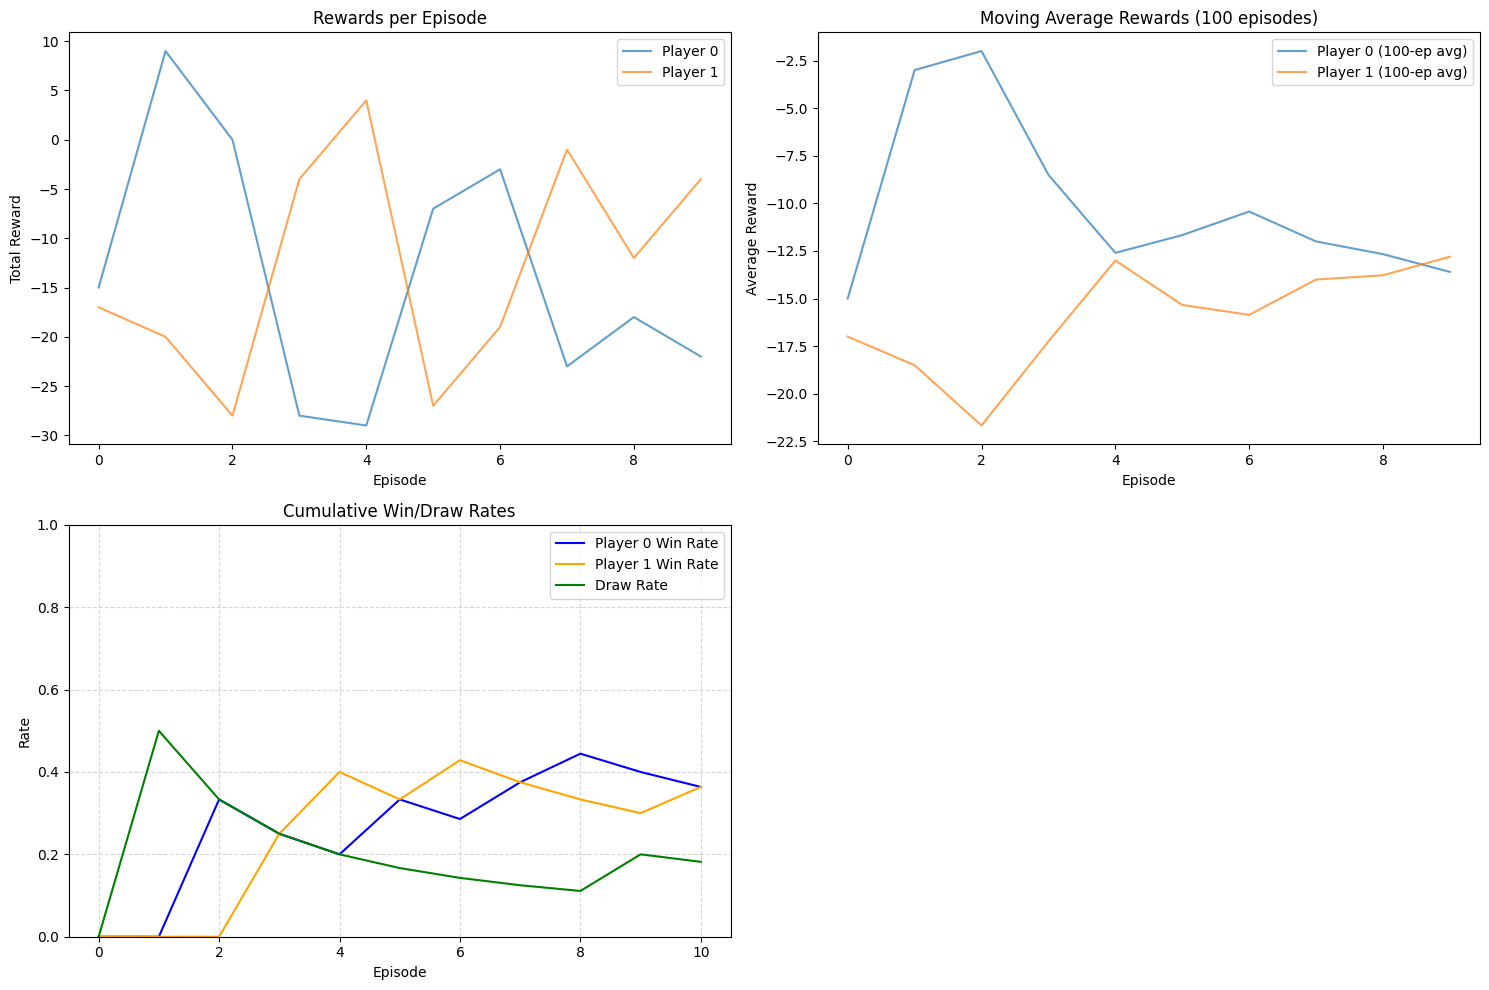

In [10]:
# Plot results
plt.figure(figsize=(15, 10))

# Plot rewards for both players
plt.subplot(2, 2, 1)
plt.plot(rewards_p0, label='Player 0', alpha=0.7)
plt.plot(rewards_p1, label='Player 1', alpha=0.7)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

# Plot moving average of rewards for better visualization
window = 100
plt.subplot(2, 2, 2)
p0_avg = [np.mean(rewards_p0[max(0, i-window):i+1]) for i in range(len(rewards_p0))]
p1_avg = [np.mean(rewards_p1[max(0, i-window):i+1]) for i in range(len(rewards_p1))]
plt.plot(p0_avg, label='Player 0 (100-ep avg)', alpha=0.7)
plt.plot(p1_avg, label='Player 1 (100-ep avg)', alpha=0.7)
plt.title("Moving Average Rewards (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

# Plot win rates for player 0
plt.subplot(2, 2, 3)

# Start from episode 1 to avoid division by zero
start_idx = 1  # Skip episode 0

# Calculate win rates as a function of episodes played
total_games = [i + 1 for i in range(len(win_counts_p0))]  # Assuming one entry per game
p0_win_rates = [wins / games for wins, games in zip(win_counts_p0, total_games)]
p1_win_rates = [wins / games for wins, games in zip(win_counts_p1, total_games)]
draw_rates = [draws / games for draws, games in zip(draw_counts, total_games)]

# Plot with matching dimensions
plt.plot(range(len(p0_win_rates)), p0_win_rates, marker='', label='Player 0 Win Rate', color='blue')
plt.plot(range(len(p1_win_rates)), p1_win_rates, marker='', label='Player 1 Win Rate', color='orange')
plt.plot(range(len(draw_rates)), draw_rates, marker='', label='Draw Rate', color='green')
plt.title("Cumulative Win/Draw Rates")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("ppo_self_play_training_results.png")
plt.show()

In [11]:
def evaluate_ppo_against_random(model_path, num_episodes=100, board_size=10, render=False):
    """
    Evaluate a trained PPO agent against a random policy.
    
    Args:
        model_path (str): Path to the saved PPO model weights
        num_episodes (int): Number of evaluation episodes
        board_size (int): Size of the board
        render (bool): Whether to render the game
        
    Returns:
        dict: Evaluation metrics including win rate
    """
    env = cathedral_v0.env(
        board_size=board_size, 
        render_mode="ansi" if render else None, 
        per_move_rewards=True, 
        final_reward_score_difference=False
    )
    env.reset()
    
    # Get observation shape and action space
    player_0 = "player_0"  # PPO agent
    player_1 = "player_1"  # Random agent
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape
    
    print(f"Loading model from {model_path}")
    
    # Initialize PPO agent
    ppo_agent = PPO(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=0.0005, 
        lr_critic=0.003,
        gamma=0.95,
        K_epochs=4,
        eps_clip=0.2
    )
    
    # Load model weights
    checkpoint = torch.load(model_path, weights_only=False)

    # Check if this is a dictionary with 'model_state_dict' key (from training function)
    if 'model_state_dict' in checkpoint:
        ppo_agent.policy.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Direct state dict (from .save() method)
        ppo_agent.policy.load_state_dict(checkpoint)
    
    # Set to evaluation mode
    ppo_agent.policy.eval()
    
    # Statistics
    stats = {
        'ppo_wins': 0,
        'random_wins': 0,
        'draws': 0,
        'ppo_rewards': [],
        'random_rewards': [],
    }
    
    for episode in range(num_episodes):
        env.reset()
        done = False
        episode_reward_ppo = 0
        episode_reward_random = 0
        
        # Print progress
        if episode % 10 == 0:
            print(f"Playing episode {episode}/{num_episodes}")
        
        while env.agents:
            current_agent = env.agent_selection
            
            if current_agent == player_1:  # PPO agent's turn
                observation = env.observe(current_agent)
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                # Use PPO to select action (deterministic for evaluation)
                with torch.no_grad():
                    action = ppo_agent.select_action(state, action_mask)
                    print(f'PPO action {action}')
                
            else:  # Random agent's turn
                observation = env.observe(current_agent)
                action_mask = observation["action_mask"]
                
                # Random valid action
                valid_actions = np.where(action_mask == 1)[0]
                action = np.random.choice(valid_actions)
                print(f'Random action {action}')
            
            # Take action
            env.step(action)
            
            # Track rewards
            if current_agent == player_1:
                episode_reward_ppo += env.rewards[current_agent]
            else:
                episode_reward_random += env.rewards[current_agent]
            
        
        print(f'Episode {episode} winner {env.winner}')
        # Record game outcome
        if env.winner == 1:  # PPO agent won
            stats['ppo_wins'] += 1
        elif env.winner == 0:  # Random agent won
            stats['random_wins'] += 1
        else:  # Draw
            stats['draws'] += 1
        
        # Record episode rewards
        stats['ppo_rewards'].append(episode_reward_ppo)
        stats['random_rewards'].append(episode_reward_random)
    
    # Calculate win rates
    stats['ppo_win_rate'] = stats['ppo_wins'] / num_episodes
    stats['random_win_rate'] = stats['random_wins'] / num_episodes
    stats['draw_rate'] = stats['draws'] / num_episodes
    
    # Calculate average rewards
    stats['avg_ppo_reward'] = sum(stats['ppo_rewards']) / num_episodes
    stats['avg_random_reward'] = sum(stats['random_rewards']) / num_episodes
    
    # Print summary
    print("\n===== Evaluation Results =====")
    print(f"Episodes played: {num_episodes}")
    print(f"PPO Wins: {stats['ppo_wins']} ({stats['ppo_win_rate']:.2%})")
    print(f"Random Wins: {stats['random_wins']} ({stats['random_win_rate']:.2%})")
    print(f"Draws: {stats['draws']} ({stats['draw_rate']:.2%})")
    print(f"Average PPO Reward: {stats['avg_ppo_reward']:.2f}")
    print(f"Average Random Reward: {stats['avg_random_reward']:.2f}")
    
    env.close()
    return stats

reset, agents are ['player_0', 'player_1']
Loading model from model_weights_random_PPO/cathedral_ppo_vs_random_final.pth
reset, agents are ['player_1', 'player_0']
Playing episode 0/50
PPO action 1647


/tmp/ipykernel_990368/203678370.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)


Random action 1156
PPO action 1298
Random action 107
PPO action 674
Random action 1051
PPO action 187
Random action 693
PPO action 778
Random action 196
PPO action 888
Random action 47
PPO action 313
Random action 752
PPO action 15
Random action 245
PPO action 1131
Random action 542
PPO action 72
 agent player_1, score 22, agent player_0 score 23
Winner 0
agents ['player_1', 'player_0'] and possible agents ['player_1', 'player_0']
Episode 0 winner 0
reset, agents are ['player_1', 'player_0']
PPO action 1752
Random action 57
PPO action 1193
Random action 905
PPO action 1
Random action 301
PPO action 519
Random action 388
PPO action 967
Random action 159
PPO action 707
Random action 1063
PPO action 127
Random action 119
PPO action 836
Random action 748
PPO action 48
Random action 31
PPO action 196
PPO action 341
 agent player_1, score 23, agent player_0 score 27
Winner 0
agents ['player_1', 'player_0'] and possible agents ['player_1', 'player_0']
Episode 1 winner 0
reset, agents are ['pl

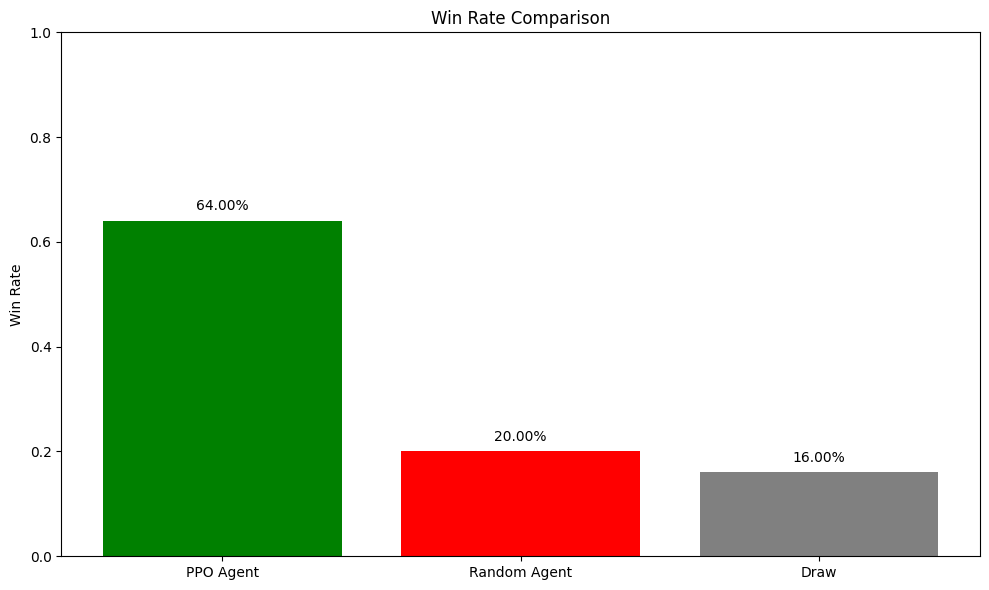

In [12]:
model_path = "model_weights_random_PPO/cathedral_ppo_vs_random_final.pth"

eval_stats = evaluate_ppo_against_random(
    model_path=model_path,
    num_episodes=50,
    board_size=8,
    render=False
)

# Create a bar chart of win rates
labels = ['PPO Agent', 'Random Agent', 'Draw']
values = [eval_stats['ppo_win_rate'], eval_stats['random_win_rate'], eval_stats['draw_rate']]
colors = ['green', 'red', 'gray']

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.title('Win Rate Comparison')
plt.ylabel('Win Rate')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.savefig('ppo_vs_random_evaluation.png')
plt.show()